In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf


# 1. import datasets

In [2]:
path = "../data/cleaned_data/resales_processed_"
resales_frames = [pd.read_csv(f"{path}{letter}") for letter in
                  ['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj']]

columns = resales_frames[0].columns
for df in resales_frames:
    df.columns = columns

resales = pd.concat(resales_frames, axis=0, ignore_index=True)

In [3]:
resales.shape

(905533, 32)

In [4]:
# check correlation between price per sqm and station_dist
resales['price_per_sqm'] = resales['resale_price'] / resales['floor_area_sqm']
resales[['price_per_sqm', 'station_dist']].corr()

,price_per_sqm,station_dist
price_per_sqm,1.000000,-0.226323
station_dist,-0.226323,1.000000


In [5]:
rentals = pd.read_csv("../data/cleaned_data/rentals_processed.csv")

# 2. linear regression

In [6]:
# copy resales dataset for linear regression
linear_resales = resales.copy()

In [7]:
# prepare month sold for categorical encoding
linear_resales['month_sold'] = pd.to_datetime(linear_resales['month_sold']).dt.month


In [8]:
# month_cal = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
#              7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# resales['month_sold'] = resales['month_sold'].map(month_cal)

In [9]:
# drop not useful things
linear_resales = linear_resales.drop(['block', 'street_name', 'building', 'address', 'postal', 'price_per_sqm', 'lease_commence_date'], axis=1)

In [10]:
train, test = train_test_split(linear_resales, test_size=0.2, random_state=42)
x_test, y_test = test.drop('resale_price', axis=1), test['resale_price']

In [11]:
selected_features = [
    'month_sold',
    'year_sold',
    'town',
    # 'flat_type',
    'flat_model',
    # 'storey_range',
    'average_storey',
    'floor_area_sqm',
    'remaining_lease',
    'resale_price',
    # 'lat',
    # 'lng',
    # 'nearest_station',
    'station_dist',
    'nearest_school_dist',
    # 'nearest_school',
    # 'nearest_mall',
    'nearest_mall_dist',
    # 'nearest_hawker',
    'nearest_hawker_dist',
    # 'nearest_supermarket',
    'nearest_supermarket_dist',
    # 'nearest_amenity',
    # 'nearest_amenity_dist',
    # 'centrality',
    'max_floor_lvl',
]

# all numeric features, will be used for polynomials
numeric_features = ['year_sold',
                    # 'month_sold',
                    'average_storey',
                    'floor_area_sqm',
                    'remaining_lease',
                    'station_dist',
                    'nearest_school_dist',
                    'nearest_mall_dist',
                    'nearest_hawker_dist',
                    'nearest_supermarket_dist',
                    'nearest_amenity_dist',
                    'max_floor_lvl',
                    'storey_percentage',
                    'nearest_park_dist',
                    'centrality'
                    ]

numeric_x_features = [name for name in numeric_features if name in selected_features]

In [12]:
# craft a formula with polynomial features
all_features = [name for name in selected_features if name != 'resale_price']

for feat in numeric_x_features:
    if feat == "nearest_mall_dist": continue # high p value, not useful
    if feat == 'nearest_hawker_dist': continue # high p value, not useful
    for i in range(2, 4):
        all_features.append(f"I({feat}**{i})")

In [13]:
resales_linear_regression = smf.ols(formula=f"resale_price ~ {' + '.join(all_features)}", data=train).fit()
resales_linear_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 5.759e+04
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:10:10   Log-Likelihood:            -9.0559e+06
No. Observations:              724426   AIC:                         1.811e+07
Df Residuals:                  724354   BIC:                         1.811e+07
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              245.2136      3.109     78.879      0.000     239.121     251.307
town[T.BEDOK]                        -4648.0686    453.139    -10.257      0.000   -5536.206   -3759.931
town[T.BISHAN]                        5.589e+04    635.177     87.999      0.000    5.46e+04    5.71e+04
town[T.BUKIT BATOK]                   -3.41e+04    596.753    -57.140      0.000   -3.53e+04   -3.29e+04
town[T.BUKIT MERAH]                   4.925e+04    562.372     87.571      0.000    4.81e+04    5.03e+04
town[T.BUKIT PANJANG]                -1.043e+05    611.224   -170.656      0.000   -1.06e+05   -1.03e+05
town[T.BUKIT TIMAH]                   8.935e+04   1515.081     58.975      0.000    8.64e+04    9.23e+04
town[T.CENTRAL AREA]                   1.63e+04   1064.424     15.311      0.000    1.42e+04    1.84e+04
town[T.CHOA CHU KANG]                -7.676e+04    657.179   -116.808      0.000   -7.81e+04   -7.55e+04
town[T.CLEMENTI]                      9664.8755    570.488     16.941      0.000    8546.737    1.08e+04
town[T.GEYLANG]                       1.228e+04    593.354     20.700      0.000    1.11e+04    1.34e+04
town[T.HOUGANG]                      -4.867e+04    567.934    -85.697      0.000   -4.98e+04   -4.76e+04
town[T.JURONG EAST]                  -4.029e+04    608.562    -66.208      0.000   -4.15e+04   -3.91e+04
town[T.JURONG WEST]                  -6.558e+04    482.064   -136.034      0.000   -6.65e+04   -6.46e+04
town[T.KALLANG/WHAMPOA]               1.749e+04    596.569     29.323      0.000    1.63e+04    1.87e+04
town[T.MARINE PARADE]                  9.39e+04    940.525     99.835      0.000    9.21e+04    9.57e+04
town[T.PASIR RIS]                    -2.177e+04    598.847    -36.361      0.000   -2.29e+04   -2.06e+04
town[T.PUNGGOL]                      -7.426e+04    758.957    -97.850      0.000   -7.58e+04   -7.28e+04
town[T.QUEENSTOWN]                    3.101e+04    636.650     48.716      0.000    2.98e+04    3.23e+04
town[T.SEMBAWANG]                    -1.102e+05    778.740   -141.521      0.000   -1.12e+05   -1.09e+05
town[T.SENGKANG]                      -9.14e+04    641.304   -142.519      0.000   -9.27e+04   -9.01e+04
town[T.SERANGOON]                     3002.4594    647.064      4.640      0.000    1734.236    4270.683
town[T.TAMPINES]                     -8007.9826    488.156    -16.405      0.000   -8964.752   -7051.213
town[T.TOA PAYOH]                     1.917e+04    575.059     33.332      0.000     1.8e+04    2.03e+04
town[T.WOODLANDS]                    -9.496e+04    509.801   -186.269      0.000    -9.6e+04    -9.4e+04
town[T.YISHUN]                       -4.418e+04    473.725    -93.261      0.000   -4.51e+04   -4.33e+04
flat_model[T.3Gen]                    

In [14]:
# r2 for train
resales_linear_regression.rsquared
# rmse for train
np.sqrt(np.mean((resales_linear_regression.predict(train) - train['resale_price']) ** 2))

64980.08706983746

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = resales_linear_regression.predict(x_test)

print ('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print ('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print ('Mean Absolute Error:', np.mean(np.abs(y_test - y_pred)))
print ('R Squared:', r2_score(y_test, y_pred))

Mean Squared Error: 4268138945.7820706
Mean Root Squared Error: 65330.99529153119
Mean Absolute Error: 50222.20591800594
R Squared: 0.8466780079244671


In [16]:
# # a bunch of regression plots idk ho to read
# # takes up to 4 mins to run

# for feat in numeric_x_features:
#     fig = plt.figure(figsize=(12, 8))
#     fig = sm.graphics.plot_regress_exog(resales_linear_regression, feat, fig=fig)

In [17]:
linear_rentals = rentals.copy()

# 2. random forest

In [18]:
random_forest_resales = resales.copy()

In [19]:
random_forest_resales['month_sold'] = pd.to_datetime(random_forest_resales['month_sold'])
# extract month from month_sold
random_forest_resales['month_sold'] = random_forest_resales['month_sold'].dt.month

random_forest_resales['month_sold']

0         9
1         7
2         7
3         7
4         7
         ..
905528    6
905529    5
905530    6
905531    4
905532    6
Name: month_sold, Length: 905533, dtype: int64

In [20]:
random_forest_resales['town'].unique()

array(['CENTRAL AREA', 'BUKIT MERAH', 'QUEENSTOWN', 'TOA PAYOH', 'BISHAN',
       'CLEMENTI', 'JURONG EAST', 'KALLANG/WHAMPOA', 'BUKIT BATOK',
       'BUKIT PANJANG', 'ANG MO KIO', 'WOODLANDS', 'SENGKANG', 'BEDOK',
       'GEYLANG', 'MARINE PARADE', 'JURONG WEST', 'CHOA CHU KANG',
       'BUKIT TIMAH', 'SEMBAWANG', 'PUNGGOL', 'HOUGANG', 'PASIR RIS',
       'TAMPINES', 'YISHUN', 'SERANGOON'], dtype=object)

In [21]:
# Included Year_sold, Month_sold
# Used OrdinalEncode

from sklearn import preprocessing

town_encoder = preprocessing.OrdinalEncoder()
random_forest_resales['town'] = town_encoder.fit_transform(random_forest_resales[['town']])

flat_type_encoder = preprocessing.OrdinalEncoder()
random_forest_resales['flat_type'] = flat_type_encoder.fit_transform(random_forest_resales[['flat_type']])

flat_model_encoder = preprocessing.OrdinalEncoder()
random_forest_resales['flat_model'] = flat_model_encoder.fit_transform(random_forest_resales[['flat_model']])


# get the categories for the 'town' feature
town_categories = town_encoder.categories_[0]
# create a mapping of town names to their encodings
town_to_encoding = {town: i for i, town in enumerate(town_categories)}

# get the categories for the 'flat_type' feature
flat_type_categories = flat_type_encoder.categories_[0]
# create a mapping of flat_type names to their encodings
flat_type_to_encoding = {flat_type: i for i, flat_type in enumerate(flat_type_categories)}

# get the categories for the 'flat_model' feature
flat_model_categories = flat_model_encoder.categories_[0]
# create a mapping of flat_model names to their encodings
flat_model_to_encoding = {flat_model: i for i, flat_model in enumerate(flat_model_categories)}

print(town_to_encoding)
print(flat_type_to_encoding)
print(flat_model_to_encoding)

# class Select(BaseEstimator, TransformerMixin):

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):

#         columns = [
#             'month_sold',
#             'year_sold',
#             'floor_area_sqm',
#             'average_storey',
#             'remaining_lease',
#             'town',
#             # 'postal',
#             'flat_type',
#             # 'flat_model',
#             'nearest_school_dist',
#             'station_dist',
#             'nearest_amenity_dist']
#         df = X.loc[:, columns].copy()

#         return df

# class OrdinalEncode(BaseEstimator, TransformerMixin):

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
#         df = X.copy()
#         enc = preprocessing.OrdinalEncoder()
#         df['month_sold'] = enc.fit_transform(df[['month_sold']])
#         # df['postal'] = enc.fit_transform(df[['postal']])
#         df['town'] = enc.fit_transform(df[['town']])
#         df['flat_type'] = enc.fit_transform(df[['flat_type']])
#         # df['flat_model'] = enc.fit_transform(df[['flat_model']])

#         return df

# pipeline = Pipeline([
#     ('SelectCol', Select()),
#     ('Encode', OrdinalEncode())
# ])

# random_forest_resales_transformed = pipeline.fit_transform(random_forest_resales)
# random_forest_resales_transformed


{'ANG MO KIO': 0, 'BEDOK': 1, 'BISHAN': 2, 'BUKIT BATOK': 3, 'BUKIT MERAH': 4, 'BUKIT PANJANG': 5, 'BUKIT TIMAH': 6, 'CENTRAL AREA': 7, 'CHOA CHU KANG': 8, 'CLEMENTI': 9, 'GEYLANG': 10, 'HOUGANG': 11, 'JURONG EAST': 12, 'JURONG WEST': 13, 'KALLANG/WHAMPOA': 14, 'MARINE PARADE': 15, 'PASIR RIS': 16, 'PUNGGOL': 17, 'QUEENSTOWN': 18, 'SEMBAWANG': 19, 'SENGKANG': 20, 'SERANGOON': 21, 'TAMPINES': 22, 'TOA PAYOH': 23, 'WOODLANDS': 24, 'YISHUN': 25}
{'1 ROOM': 0, '2 ROOM': 1, '3 ROOM': 2, '4 ROOM': 3, '5 ROOM': 4, 'EXECUTIVE': 5, 'MULTI-GENERATION': 6}
{'2-Room': 0, '3Gen': 1, 'Adjoined Flat': 2, 'Apartment': 3, 'Dbss': 4, 'Improved': 5, 'Improved-Maisonette': 6, 'Maisonette': 7, 'Model A': 8, 'Model A-Maisonette': 9, 'Model A2': 10, 'Multi Generation': 11, 'New Generation': 12, 'Premium Apartment': 13, 'Premium Apartment Loft': 14, 'Premium Maisonette': 15, 'Simplified': 16, 'Standard': 17, 'Terrace': 18, 'Type S1': 19, 'Type S2': 20}


In [22]:
random_forest_resales['flat_model'].unique()

array([19., 20.,  5.,  8., 13., 14.,  4., 17.,  0.,  7.,  3., 12.,  2.,
        9.,  1., 10., 15., 16.,  6., 11., 18.])

In [23]:
# how to show all columns
pd.set_option('display.max_columns', None)
resales.sample()

,month_sold,year_sold,town,block,street_name,building,address,postal,flat_type,flat_model,storey_range,average_storey,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,price_per_sqm,lat,lng,nearest_station,station_dist,nearest_school_dist,nearest_school,nearest_mall,nearest_mall_dist,nearest_hawker,nearest_hawker_dist,nearest_supermarket,nearest_supermarket_dist,nearest_amenity,nearest_amenity_dist,max_floor_lvl
499104,2013-05-01,2013,BUKIT PANJANG,250,BANGKIT RD,NIL,250 BANGKIT ROAD SINGAPORE 670250,670250,3 ROOM,Model A,"[7, 9]",8,73.0,1988,74,357800.0,4901.369863,1.380655,103.773699,BANGKIT LRT STATION (BP9),0.136456,0.366503,Beacon Primary School,Fajar Shopping Centre,0.452224,Bukit Panjang Hawker Centre & Market,0.365628,256 BANGKIT ROAD,0.194749,256 BANGKIT ROAD,0.194749,12.0


Train MSE: 477070098.766257
Test MSE: 615655895.4697583
Train R^2: 0.9829965049939201
Test R^2: 0.9778841341564682

Train MAE: 16059.52116215829
Test MAE: 17440.477112165183
Train RMSE: 21841.93440989733
Test RMSE: 24812.414140299978



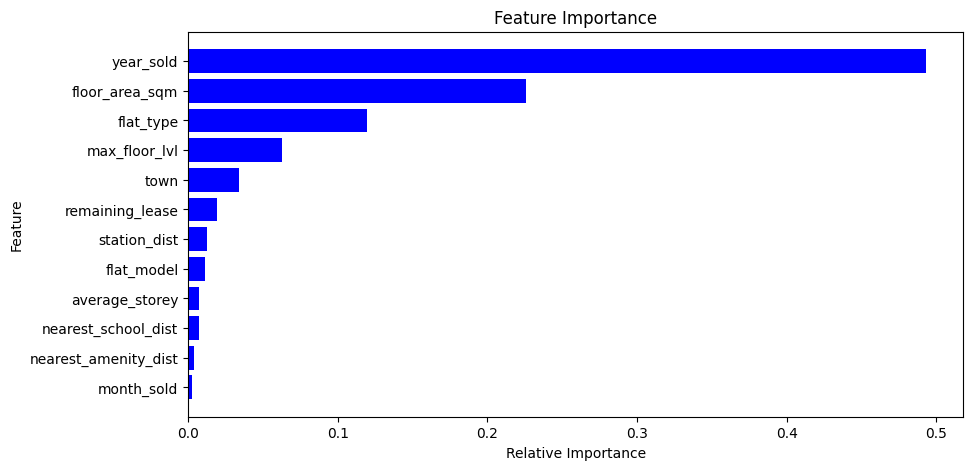

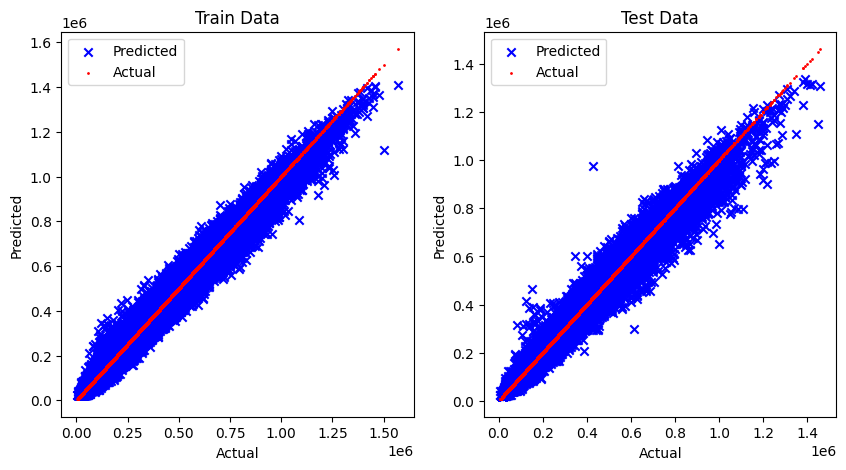

In [24]:
# runs in a minute or so

# Random split train-test
# n_estimators=150
# max_depth=9500
# max_leaf_nodes=9501

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import numpy as np

random_forest_resales = random_forest_resales[[
            'month_sold',
            'year_sold',
            'floor_area_sqm',
            'average_storey',
            'remaining_lease',
            'town',
            # 'postal',
            'flat_type',
            'flat_model',
            'nearest_school_dist',
            'station_dist',
            'nearest_amenity_dist',
            'max_floor_lvl',
            'resale_price']]

resales_train, resales_test = train_test_split(random_forest_resales, test_size=0.2, random_state=42)
X_train, X_test = resales_train.drop('resale_price', axis=1), resales_test.drop('resale_price', axis=1)

# # For standardization
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # For normalization
# normalizer = MinMaxScaler()
# X_train_normalized = normalizer.fit_transform(X_train)
# X_test_normalized = normalizer.transform(X_test)

Y_train, Y_test = resales_train['resale_price'], resales_test['resale_price']

rf = RandomForestRegressor(n_jobs=-1, n_estimators=150, max_depth=9500, max_leaf_nodes=9501, max_samples=0.5, max_features=0.7, random_state = 42)
rf.fit(X_train, Y_train)

Y_train_pred_rf = rf.predict(X_train)
Y_test_pred_rf = rf.predict(X_test)

train_mse = mean_squared_error(Y_train, Y_train_pred_rf)
test_mse = mean_squared_error(Y_test, Y_test_pred_rf)
train_r2 = r2_score(Y_train, Y_train_pred_rf)
test_r2 = r2_score(Y_test, Y_test_pred_rf)
train_mae = mean_absolute_error(Y_train, Y_train_pred_rf)
test_mae = mean_absolute_error(Y_test, Y_test_pred_rf)
train_rmse = sqrt(mean_squared_error(Y_train, Y_train_pred_rf))
test_rmse = sqrt(mean_squared_error(Y_test, Y_test_pred_rf))

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')
print()
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print()

# Feature importance
plt.figure(figsize=(10, 5))
importances = rf.feature_importances_
indices = np.argsort(importances)

# colour scheme

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Plot Y_train vs Y_train_pred and Y_test vs Y_test_pred
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y_train, Y_train_pred_rf, color='blue', label='Predicted', marker = 'x')
plt.scatter(Y_train, Y_train, color='red', label='Actual', s = 1)
plt.title('Train Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_test_pred_rf, color='blue', label='Predicted', marker = 'x')
plt.scatter(Y_test, Y_test, color='red', label='Actual', s = 1)
plt.title('Test Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.show()

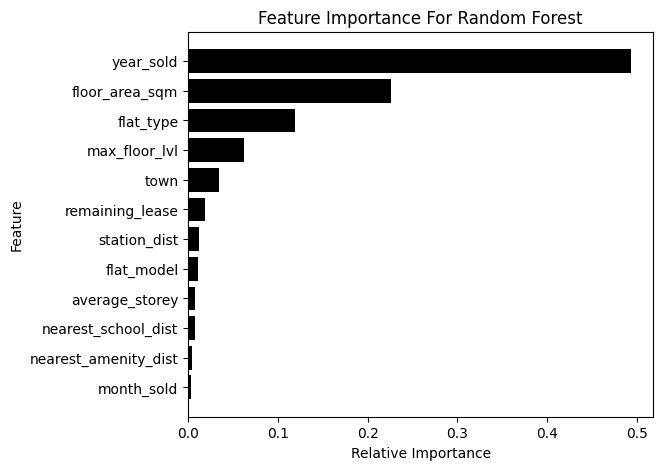

In [25]:
plt.figure(figsize=(6, 5))
plt.barh(range(len(indices)), importances[indices], color='black', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Feature Importance For Random Forest')
plt.show()

Text(0, 0.5, 'Residuals')

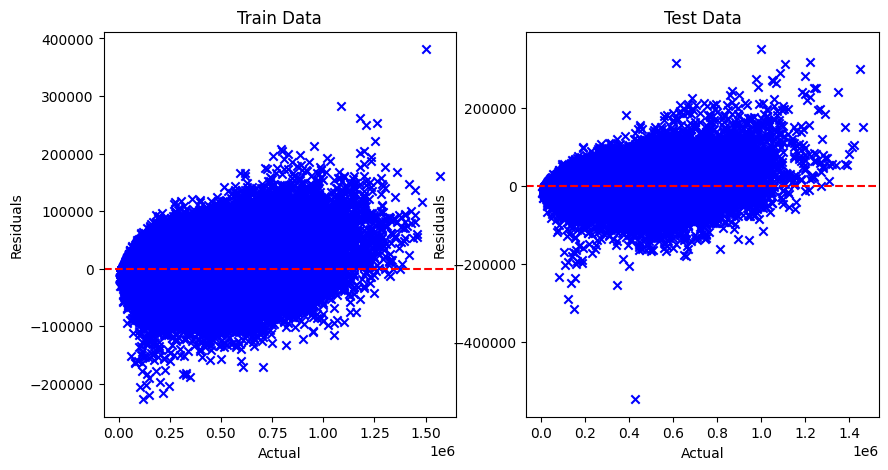

In [26]:
# plot residuals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

residuals_train = Y_train - Y_train_pred_rf
plt.scatter(Y_train, residuals_train, color='blue', marker = 'x')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Train Data')
plt.xlabel('Actual')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
residuals_test = Y_test - Y_test_pred_rf
plt.scatter(Y_test, residuals_test, color='blue', marker = 'x')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Test Data')
plt.xlabel('Actual')
plt.ylabel('Residuals')

In [27]:
test_errors = pd.DataFrame({'actual': Y_test, 'predicted': Y_test_pred_rf, 'residual': residuals_test})
test_errors['residual'] = test_errors['residual'].abs()
test_errors['percentage_error'] = (test_errors['residual'] / test_errors['actual']) * 100
test_errors['percentage_error'].mean()

6.370854202748489

In [28]:
train_errors = pd.DataFrame({'actual': Y_train, 'predicted': Y_train_pred_rf, 'residual': residuals_train})
train_errors['residual'] = train_errors['residual'].abs()
train_errors['percentage_error'] = (train_errors['residual'] / train_errors['actual']) * 100
train_errors['percentage_error'].mean()

6.030942732104043

In [29]:
# Cross-validation - runs in 7.5 mins

# Random split train-test
# n_estimators=150
# max_depth=9500
# max_leaf_nodes=9501

from sklearn.model_selection import cross_validate, KFold

X = random_forest_resales.drop('resale_price', axis=1)
Y = random_forest_resales['resale_price']

cv = KFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
}

cv_results = cross_validate(rf, X, Y, cv=cv, scoring=scoring, return_train_score=False)

for score_name, scores in cv_results.items():
    if score_name.startswith("test_"):
        if "MSE" in score_name or "MAE" in score_name or "RMSE" in score_name:
            scores = -scores
        print(f"{score_name.replace('test_', '')}: Mean = {scores.mean()}, Std = {scores.std()}")

MSE: Mean = 605460961.7697322, Std = 7823395.975146528
R2: Mean = 0.9783860249269093, Std = 0.00028846699557581696
MAE: Mean = 17358.271050992833, Std = 55.58177461143277
RMSE: Mean = 24605.603122572986, Std = 158.92370546503165


In [30]:
# # save the models
# from joblib import dump

# # dump models
# dump(rf, 'rf/random_forest_resales.joblib')

# 3. xgboost

In [31]:
xgboost_resales = resales.copy()

In [32]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

xgboost_resales['month_sold'] = pd.to_datetime(xgboost_resales['month_sold']).dt.month
label_encoder = LabelEncoder()
xgboost_resales['month_sold'] = label_encoder.fit_transform(xgboost_resales['month_sold'])
xgboost_resales['flat_type'] = label_encoder.fit_transform(xgboost_resales['flat_type'])

xgboost_resales['mean_nearest_supermarket_amenity_dist'] = xgboost_resales[['nearest_supermarket_dist', 'nearest_amenity_dist']].mean(axis=1)

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(xgboost_resales[['lat', 'lng']])
xgboost_resales['location_cluster'] = kmeans.labels_

/Users/seaheewei/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
# one hot encoding the flat model
ohe = OneHotEncoder()
flat_model_ohe = ohe.fit_transform(xgboost_resales[['flat_model']]).toarray()
flat_model_df = pd.DataFrame(flat_model_ohe, columns=ohe.categories_[0])
xgboost_resales = pd.concat([xgboost_resales, flat_model_df], axis=1)

In [35]:
# dropping features
xgboost_resales = xgboost_resales.drop(['block', 'street_name', 'building', 'address', 'flat_model','nearest_hawker', 'price_per_sqm', 'lat', 'lng','storey_range','nearest_school', 'nearest_mall', 'nearest_supermarket','nearest_amenity','nearest_supermarket_dist', 'nearest_amenity_dist'], axis=1)

In [36]:
# features to be trained on
xgboost_resales.columns

Index(['month_sold', 'year_sold', 'town', 'postal', 'flat_type',
       'average_storey', 'floor_area_sqm', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'nearest_station', 'station_dist',
       'nearest_school_dist', 'nearest_mall_dist', 'nearest_hawker_dist',
       'max_floor_lvl', 'mean_nearest_supermarket_amenity_dist',
       'location_cluster', '2-Room', '3Gen', 'Adjoined Flat', 'Apartment',
       'Dbss', 'Improved', 'Improved-Maisonette', 'Maisonette', 'Model A',
       'Model A-Maisonette', 'Model A2', 'Multi Generation', 'New Generation',
       'Premium Apartment', 'Premium Apartment Loft', 'Premium Maisonette',
       'Simplified', 'Standard', 'Terrace', 'Type S1', 'Type S2'],
      dtype='object')

In [37]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(xgboost_resales, test_size=0.2, random_state=42)

# separate features and target variable
X_train, X_test = train.drop('resale_price', axis=1), test.drop('resale_price', axis=1)
y_train, y_test = train['resale_price'], test['resale_price']

In [38]:
import category_encoders as ce
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Apply target encoding
encoder = ce.TargetEncoder(cols=['town'])
# Fit and transform the encoder on the training set
X_train['town'] = encoder.fit_transform(X_train['town'], y_train)
# Transform the encoder on the test set
X_test['town'] = encoder.transform(X_test['town'])

# Create an instance of the target encoder, specifying the column to encode
encoder = ce.TargetEncoder(cols=['nearest_station'])

# Fit the encoder using the training data
encoder.fit(X_train['nearest_station'], y_train)

# Directly update the 'nearest_station' column in X_train and X_test
X_train['nearest_station'] = encoder.transform(X_train['nearest_station'])
X_test['nearest_station'] = encoder.transform(X_test['nearest_station'])

In [39]:
# Initialize the XGBoost model and set hyperparameters
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.2,
    objective='reg:squarederror',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Compute and print evaluation metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = sqrt(train_mse)
test_rmse = sqrt(test_mse)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train MSE: 454157408.75873363
Test MSE: 475693554.31428564
Train R^2: 0.9838131476867368
Test R^2: 0.9829119238404754
Train MAE: 15283.66126851832
Test MAE: 15482.831630561943
Train RMSE: 21310.96921209201
Test RMSE: 21810.400141086033


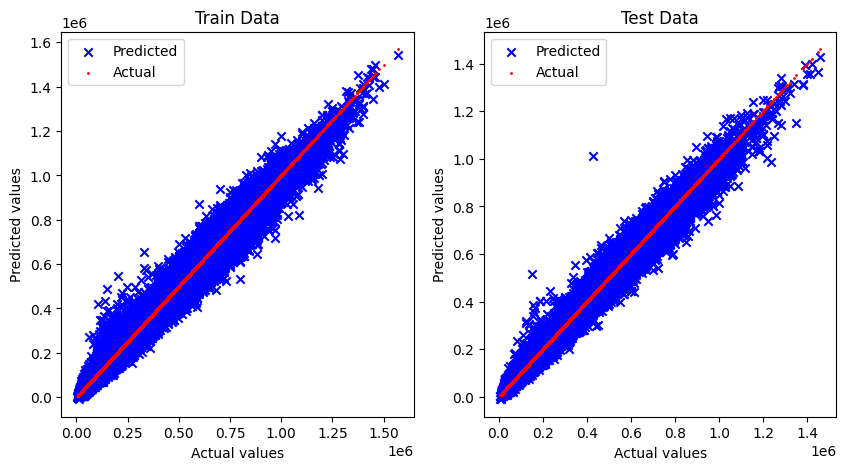

In [40]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', label='Predicted', marker='x')
plt.scatter(y_train, y_train, color='red', label='Actual', s=1)
plt.title('Train Data')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted', marker='x')
plt.scatter(y_test, y_test, color='red', label='Actual', s=1)
plt.title('Test Data')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()

plt.show()


In [41]:
X_test

,month_sold,year_sold,town,postal,flat_type,average_storey,floor_area_sqm,lease_commence_date,remaining_lease,nearest_station,station_dist,nearest_school_dist,nearest_mall_dist,nearest_hawker_dist,max_floor_lvl,mean_nearest_supermarket_amenity_dist,location_cluster,2-Room,3Gen,Adjoined Flat,Apartment,Dbss,Improved,Improved-Maisonette,Maisonette,Model A,Model A-Maisonette,Model A2,Multi Generation,New Generation,Premium Apartment,Premium Apartment Loft,Premium Maisonette,Simplified,Standard,Terrace,Type S1,Type S2
549921,8,2021,333575.680980,520411,2,8,69.0,1985,63,328689.884438,0.571262,0.316851,0.744446,0.901634,12.0,0.354274,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
685911,0,2004,311822.624997,730664,3,2,100.0,1998,93,333577.384157,0.603655,0.155772,0.294429,0.524541,12.0,0.294431,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607022,4,2001,258741.777914,560547,3,11,92.0,1981,79,265301.342932,1.073219,0.710664,1.184446,0.446771,12.0,0.420245,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34390,2,2012,324427.625490,321103,4,13,135.0,1984,71,309563.225867,0.830943,0.822207,0.613467,0.457936,25.0,0.490261,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15973,5,2018,258741.777914,561308,2,5,70.0,2012,93,265301.342932,0.784449,0.604522,0.642765,0.475651,30.0,0.272108,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500360,2,2010,268748.216386,760287,3,8,104.0,1985,74,248702.600246,1.173542,0.193925,0.842700,1.371638,12.0,0.390923,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297556,11,1998,274662.466026,461037,2,14,66.0,1983,84,246745.547603,0.450372,0.667194,0.340354,0.490646,14.0,0.217932,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407320,5,2016,326125.308436,550109,3,8,93.0,1985,68,371528.533205,1.917951,0.607902,0.764797,0.728676,13.0,0.283641,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497276,0,2013,268748.216386,760394,2,11,73.0,1989,75,248702.600246,1.464433,0.150466,0.863784,0.575272,12.0,0.207763,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
